##DOC2VEC


In [3]:
import pandas as pd
import tensorflow as tf
import sklearn
import numpy as np


np.random.seed(2023)
tf.random.set_seed(2023)

In [4]:
df = pd.read_csv('oversample_stemmed_train_df.csv')
df.head(3)

,text,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,...,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges,prep_text
0,"Szukam miejsc, w których mogę zrelaksować się...",2,3,2,2,3,2,2,2,4,...,4,3,3,3,3,2,4,4,4,szukać miejsce w który móc zrelaksować wokół p...
1,Moje zainteresowania leżą w literaturze i sztu...,1,2,1,2,3,1,1,1,2,...,5,3,3,2,2,2,3,5,3,zainteresowanie leż w literatura i sztuca któr...
2,"Lubię także odwiedzać miejsca w sercu natury, ...",1,3,2,2,2,1,1,1,2,...,5,2,1,1,2,2,4,5,3,lubić także odwiedzać miejsce w serce natura a...


In [5]:
texts = df['prep_text']
texts

0       szukać miejsce w który móc zrelaksować wokół p...
1       zainteresowanie leż w literatura i sztuca któr...
2       lubić także odwiedzać miejsce w serce natura a...
3       skupiać zapewniać dziecko przyjemny doświadcze...
4       fan nowy technologia i uwielbiać odkrywać miej...
                              ...                        
2295    spokojny osoba czerpać wielki przyjemność z ha...
2296    mama powinowactwo przyroda i aktywny zajęcia r...
2297    ekolog środowiskowy zainteresowany zrównoważon...
2298    lubić zarówno wiedza naukowy i emocje związać ...
2299    pasjonat sport który preferować aktywność fizy...
Name: prep_text, Length: 2300, dtype: object

In [6]:
df = df.drop(['text', 'prep_text'], axis=1)
df

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,2,3,2,2,3,2,2,2,4,4,...,4,4,3,3,3,3,2,4,4,4
1,1,2,1,2,3,1,1,1,2,4,...,4,5,3,3,2,2,2,3,5,3
2,1,3,2,2,2,1,1,1,2,4,...,4,5,2,1,1,2,2,4,5,3
3,5,4,5,4,4,3,4,3,4,5,...,4,4,4,4,5,5,4,4,4,4
4,2,3,1,1,1,1,1,1,2,2,...,3,4,2,1,1,1,4,5,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,2,3,3,2,3,2,3,2,3,4,...,4,4,3,3,4,4,3,3,4,4
2296,2,1,4,2,3,5,1,1,4,5,...,3,4,1,2,4,4,1,3,4,3
2297,2,3,4,2,3,2,2,1,4,5,...,3,4,2,2,4,3,4,4,3,4
2298,2,3,2,1,1,2,1,1,3,2,...,3,4,1,4,1,2,3,4,3,2


In [7]:
df.columns

Index(['amusement_parks', 'ferris_wheels', 'water_parks', 'miniature_parks',
       'baths_and_saunas', 'climbing', 'stadiums', 'winter_sports',
       'natural_springs', 'water', 'nature_reserves', 'beaches',
       'railway_stations', 'dams', 'mints', 'mineshafts', 'science_museums',
       'churches', 'cathedrals', 'monasteries', 'synagogues', 'hindu_temples',
       'mosques', 'archaeology', 'castles', 'fortified_towers', 'bunkers',
       'military_museums', 'battlefields', 'war_graves', 'cemeteries',
       'mausoleums', 'crypts', 'monuments', 'tumuluses', 'wall_painting',
       'fountains', 'sculptures', 'gardens_and_parks',
       'archaeological_museums', 'art_galleries', 'biographical_museums',
       'history_museums', 'local_museums', 'national_museums',
       'fashion_museums', 'planetariums', 'zoos', 'aquariums', 'skyscrapers',
       'towers', 'historic_architecture', 'bridges'],
      dtype='object')

In [8]:
df['mean'] = df.mean(axis=1)
df['mean']

0       3.169811
1       3.056604
2       3.094340
3       4.056604
4       1.962264
          ...   
2295    3.226415
2296    2.490566
2297    2.716981
2298    2.037736
2299    2.377358
Name: mean, Length: 2300, dtype: float64

In [9]:
df.head(2)

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges,mean
0,2,3,2,2,3,2,2,2,4,4,...,4,3,3,3,3,2,4,4,4,3.169811
1,1,2,1,2,3,1,1,1,2,4,...,5,3,3,2,2,2,3,5,3,3.056604


In [10]:
cols = list(df.columns)
cols.remove('mean')

In [11]:
pref_df = pd.DataFrame()

for col in cols:
  pref_df[col] = df[col] >= df['mean']

pref_df.astype(int)

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,0,0,0,0,0,0,0,0,1,1,...,1,1,0,0,0,0,0,1,1,1
1,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,1,1,0
3,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
4,1,1,0,0,0,0,0,0,1,1,...,1,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,1,1,0,0,1,1
2296,0,0,1,0,1,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,1
2297,0,1,1,0,1,0,0,0,1,1,...,1,1,0,0,1,1,1,1,1,1
2298,0,1,0,0,0,0,0,0,1,0,...,1,1,0,1,0,0,1,1,1,0


In [12]:
print('Like PoI only if higher than mean.')
print(f'mean liked: {sum(pref_df.sum(axis=1))/2300}')
print(f'max liked: {max(pref_df.sum(axis=1))}')
print(f'min liked: {min(pref_df.sum(axis=1))}')

Like PoI only if higher than mean.
mean liked: 23.41304347826087
max liked: 39
min liked: 2


In [13]:
df['median'] = df.median(axis=1)
df.head(2)

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges,mean,median
0,2,3,2,2,3,2,2,2,4,4,...,3,3,3,3,2,4,4,4,3.169811,3.0
1,1,2,1,2,3,1,1,1,2,4,...,3,3,2,2,2,3,5,3,3.056604,3.0


In [14]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

doc2vec_model = Doc2Vec.load('doc2vec_model_wibit')

text_vectors = [doc2vec_model.infer_vector(text.split(' ')) for text in texts]

In [15]:
text_vectors[1]

array([-0.4714137 , -0.46885368, -0.25221217, -0.7837495 ,  0.6517004 ,
        1.266478  ,  0.1581454 ,  1.2625084 , -0.46088293, -0.53763294,
       -0.36975563, -1.1364928 ,  0.04703078,  1.1338905 , -0.42548317,
       -0.43031865,  0.9556617 , -0.8041836 , -1.1913571 , -0.389945  ,
       -0.7233677 ,  0.6768777 ,  0.5388471 , -0.74249446, -0.97732496,
       -0.72789055, -0.36775574,  1.1648177 , -1.3507714 , -0.20195307,
       -1.0279788 , -0.25079843, -0.05670609, -0.00976216, -0.30927366,
       -0.03357551,  0.78544146, -0.63022804,  0.07513241,  0.12847897,
        0.6973074 , -0.53723484,  0.64871067,  0.14944926, -0.42526117,
        0.11363016,  0.60273   ,  0.20600477,  0.09700446, -0.24026944,
        0.46189493,  0.3359947 , -0.5409709 ,  0.27262428,  0.87267756,
        0.46470934, -0.362719  , -0.5500802 ,  0.704903  ,  0.80100757,
        0.5872458 ,  0.11305978, -1.1420491 , -0.15699507, -0.16151774,
        0.04996215,  0.28817692,  1.4373535 , -0.5879251 , -0.25

In [16]:
X = pd.DataFrame(text_vectors)
X.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.255641,0.668722,0.608213,-0.803281,0.880835,-0.705666,-0.147351,1.911838,-0.670788,-0.207499,...,0.805351,-0.951943,0.268529,0.179795,0.007731,0.097069,-0.471055,-0.572555,0.578045,0.335043
1,-0.471414,-0.468854,-0.252212,-0.783750,0.651700,1.266478,0.158145,1.262508,-0.460883,-0.537633,...,0.019051,-0.024757,0.770271,1.004185,0.399640,1.558273,-1.467264,-0.480543,0.254172,0.864513
2,0.116535,-0.383215,-0.153229,-0.494437,-0.433953,-0.390048,-0.622404,1.060959,0.025720,0.093469,...,-0.302565,-0.983626,0.218039,0.530493,0.556364,-1.123323,-0.264816,0.720802,0.751379,-0.423218


In [17]:
y = pref_df.astype(int)
y.head(3)

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,0,0,0,0,0,0,0,0,1,1,...,1,1,0,0,0,0,0,1,1,1
1,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,1,1,0


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


INPUT_SHAPE = 100


model = Sequential([
    Dense(96, activation='relu', input_shape=(INPUT_SHAPE,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(53, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                9696      
                                                                 
 dense_1 (Dense)             (None, 64)                6208      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 53)                1749      
                                                                 
Total params: 19733 (77.08 KB)
Trainable params: 19733 (77.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
result = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.15)

Epoch 1/20
62/62 [==============================] - 6s 7ms/step - loss: 0.5376 - accuracy: 0.0026 - val_loss: 0.4959 - val_accuracy: 0.0029
Epoch 2/20
62/62 [==============================] - 0s 5ms/step - loss: 0.4715 - accuracy: 5.1151e-04 - val_loss: 0.4774 - val_accuracy: 0.0029
Epoch 3/20
62/62 [==============================] - 0s 4ms/step - loss: 0.4405 - accuracy: 0.0010 - val_loss: 0.4596 - val_accuracy: 0.0058
Epoch 4/20
62/62 [==============================] - 0s 4ms/step - loss: 0.4173 - accuracy: 0.0051 - val_loss: 0.4693 - val_accuracy: 0.0145
Epoch 5/20
62/62 [==============================] - 0s 4ms/step - loss: 0.3946 - accuracy: 0.0066 - val_loss: 0.4669 - val_accuracy: 0.0232
Epoch 6/20
62/62 [==============================] - 0s 4ms/step - loss: 0.3755 - accuracy: 0.0133 - val_loss: 0.4695 - val_accuracy: 0.0174
Epoch 7/20
62/62 [==============================] - 0s 5ms/step - loss: 0.3570 - accuracy: 0.0107 - val_loss: 0.4923 - val_accuracy: 0.0232
Epoch 8/20
62/62

In [20]:
pred_Y = model.predict([[0 for i in range(100)]])

1/1 [==============================] - 0s 255ms/step


In [21]:
pred_Y[0]

array([0.5178852 , 0.7073106 , 0.34900585, 0.21756591, 0.5354615 ,
       0.36939785, 0.48278603, 0.1781896 , 0.5510241 , 0.8317159 ,
       0.64327574, 0.3241407 , 0.6331549 , 0.39744064, 0.03069291,
       0.15871987, 0.5453739 , 0.7237823 , 0.5175828 , 0.42779884,
       0.28183645, 0.25721443, 0.16050142, 0.63760144, 0.8448971 ,
       0.67689645, 0.15978439, 0.4929854 , 0.23098926, 0.45935747,
       0.535622  , 0.4808216 , 0.16901448, 0.8654253 , 0.06911165,
       0.13930644, 0.45771235, 0.39370564, 0.80017304, 0.6846996 ,
       0.6011611 , 0.27628034, 0.9028751 , 0.6452594 , 0.9442487 ,
       0.10377724, 0.18620385, 0.46035418, 0.11622024, 0.49166125,
       0.9249113 , 0.9230347 , 0.90595734], dtype=float32)

In [22]:
def get_attr_from_vector(vector, threshold=0.5):
  return [1 if elem >= threshold else 0 for elem in vector]


In [23]:
np.array(get_attr_from_vector(pred_Y[0]))

array([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1])

In [24]:
test_df = pd.read_csv('test_df.csv')
test_df.head(3)

,text,date,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,"Interesuję się matematyką, fizyką, grami kompu...",od 2 do 10 sierpnia,3,0,4,1,1,1,0,1,...,2,2,0,4,2,2,1,1,3,1
1,"Jestem studentem historii, z pasją do eksplora...",Moja wycieczka odbędzie się od 3 czerwca do 18...,1,2,1,1,1,1,1,1,...,4,5,1,1,1,1,1,3,5,2
2,"Interesuję się gotowaniem i pieczeniem, często...",Od 13 do 17 listopada,4,4,2,1,2,4,1,0,...,1,3,1,1,3,3,1,2,2,2


In [25]:
! pip install stop_words pyMorfologik

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=7d7c766232dfb3ecb328ba3d7e6ca88946b065fff68ed8bfb4f883e34f56b980
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
  Created wheel for pyMorfologik: filename=pyMorfologik-0.2.2-py3-none-any.whl size=3595603 sha256=2964e33033f15ba24d8eccce81c19ad071aab362e5a27ce0147021d77737cf5a
  Stored in directory: /root/.cache/pip/wheels/c5/7b/f8/1d75b1eb41c0ab7ef6a5d621a1e25094554db8556287a297f4
Successfully built stop_words pyMorfologik


In [26]:
import re
import string
from stop_words import get_stop_words
from pyMorfologik import Morfologik
from pyMorfologik.parsing import ListParser


parser = ListParser()
stemmer = Morfologik()

stopwords_pl = get_stop_words("pl")


def preprocess_text(text):
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    new_text = text.translate(translator)
    new_text = re.sub(r'\d+', '', new_text)
    new_text = re.sub(r'\s+', ' ', new_text)
    new_text = new_text.strip()
    new_text = new_text.lower()

    stems = stemmer.stem([new_text], parser)
    tokens = [(list(stems[i][1].keys())[0] if len(list(stems[i][1].keys())) > 0 else stems[i][0]) for i in range(len(stems))]

    filtered_tokens = [token for token in tokens if token not in stopwords_pl]
    filtered_tokens = [token for token in filtered_tokens if token!= '']
    processed_text = " ".join(filtered_tokens)

    return processed_text


In [27]:
test_texts = [preprocess_text(text) for text in test_df['text']]
test_texts[:3]

['interesować matematyka fizyka gra komputerowy i planszowy lubić słuchać muzyk szczególnie elektroniczny w wolny czas gram w gra często karciany turowy czytać też książka czas oglądać serial ulubiony tematyka fantasy i science fiction lubić dowiadywać zaskakujący rzecz różny temat wola spędzać czas raczej otoczyć przyroda zgiełk miasto lubić eksperymentować z nowy smak',
 'student historia z pasja eksploracja muzeum i fascynacja miejsce o bogaty historia hobby zgłębiać przeszłość i odkrywać dziedzictwo kulturowy wolny czas chętnie spędzać w miejsce który świadek ważny wydarzenie historyczny',
 'interesować gotowanie i pieczenie często robić w wolny czas lubić także tańczyć tańce towarzyski preferować aktywny sposób spędzać czas ale przepadać za zwiedzać architektura historyczny zabytek wola raczej ciekawy i mniej typowy opcja lubić jeść posiłki w spokojny miejsce próbować nowy rzecz szczególnie z kuchnia polski włoski hiszpański i meksykański']

In [28]:
y_test = test_df.drop(['text', 'date'], axis=1)
y_test.head(3)

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,3,0,4,1,1,1,0,1,1,4,...,2,2,0,4,2,2,1,1,3,1
1,1,2,1,1,1,1,1,1,1,2,...,4,5,1,1,1,1,1,3,5,2
2,4,4,2,1,2,4,1,0,0,3,...,1,3,1,1,3,3,1,2,2,2


In [29]:
y_test['mean'] = y_test.mean(axis=1)

In [30]:
y_test_scaled = pd.DataFrame()

for col in cols:
  y_test_scaled[col] = y_test[col] >= y_test['mean']

y_test_scaled = y_test_scaled.astype(int)
y_test_scaled.head(3)

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,0
2,1,1,1,0,1,1,0,0,0,1,...,0,1,0,0,1,1,0,1,1,1


In [31]:
X_test = pd.DataFrame([doc2vec_model.infer_vector(text.split(' ')) for text in test_texts])
X_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-1.220638,1.479412,0.889769,2.124974,-1.791681,0.299194,1.910590,-0.103221,1.542674,-0.088718,...,0.638644,0.132876,2.581066,1.058974,0.386026,-2.410265,0.792494,-1.446567,1.011056,0.294409
1,-0.412666,-0.637437,0.404475,0.174389,0.920357,1.418394,0.608451,0.530535,-0.113844,0.024840,...,0.097786,-1.588196,-1.422374,0.931426,-0.061218,-0.695693,0.697207,0.927840,0.391241,-0.778736


In [32]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 229ms/step


In [33]:
y_pred_cat = pd.DataFrame([get_attr_from_vector(vector, threshold=0.5) for vector in y_pred])

In [34]:
y_pred_cat.columns = cols

In [35]:
y_pred_cat.head(3)

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,1,0,0,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,1,0,...,1,1,0,1,0,0,1,1,1,1
2,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,1,1,1,1


In [36]:
y_test_scaled.head(3)

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,0
2,1,1,1,0,1,1,0,0,0,1,...,0,1,0,0,1,1,0,1,1,1


In [37]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

total_ac = 0
total_rec = 0
total_prec = 0

size = 26

for i in range(size):
  tmp_pred = y_pred_cat.iloc[i]
  tmp_true = y_test_scaled.iloc[i]

  ac_score = accuracy_score(tmp_pred, tmp_true)
  rec_score = recall_score(tmp_pred, tmp_true)
  prec_score = precision_score(tmp_pred, tmp_true)

  total_ac += ac_score
  total_rec += rec_score
  total_prec += prec_score

  doc2vec_simple_nn_accuracy = total_ac/size
  doc2vec_simple_nn_recall = total_rec/size
  doc2vec_simple_nn_precision = total_prec/size

  print(f"{i} - Accuracy: {ac_score} | Recall: {rec_score} | Precision: {prec_score}")


print(f"\nMean - Accuracy: {total_ac/size } | Recall: {total_rec/size} | Precision: {total_prec/size}")

0 - Accuracy: 0.6226415094339622 | Recall: 0.47058823529411764 | Precision: 0.42105263157894735
1 - Accuracy: 0.6226415094339622 | Recall: 0.6666666666666666 | Precision: 0.46153846153846156
2 - Accuracy: 0.6792452830188679 | Recall: 0.7142857142857143 | Precision: 0.5769230769230769
3 - Accuracy: 0.6981132075471698 | Recall: 0.8181818181818182 | Precision: 0.6
4 - Accuracy: 0.6981132075471698 | Recall: 0.7916666666666666 | Precision: 0.6333333333333333
5 - Accuracy: 0.8301886792452831 | Recall: 0.9310344827586207 | Precision: 0.7941176470588235
6 - Accuracy: 0.7547169811320755 | Recall: 1.0 | Precision: 0.5185185185185185
7 - Accuracy: 0.6792452830188679 | Recall: 0.5652173913043478 | Precision: 0.65
8 - Accuracy: 0.7169811320754716 | Recall: 0.6666666666666666 | Precision: 0.6363636363636364
9 - Accuracy: 0.7924528301886793 | Recall: 0.7391304347826086 | Precision: 0.7727272727272727
10 - Accuracy: 0.5471698113207547 | Recall: 0.75 | Precision: 0.4411764705882353
11 - Accuracy: 0.509

In [38]:
total_ac = 0

for col in cols:
  ac_score = accuracy_score(y_pred_cat[col], y_test_scaled[col])
  total_ac += ac_score
  print(f"Accuracy of predicting {col}: {ac_score}")

print(f"\nMean accuracy in test dataset: {total_ac/len(cols)}")

Accuracy of predicting amusement_parks: 0.7692307692307693
Accuracy of predicting ferris_wheels: 0.5384615384615384
Accuracy of predicting water_parks: 0.6923076923076923
Accuracy of predicting miniature_parks: 0.7692307692307693
Accuracy of predicting baths_and_saunas: 0.6153846153846154
Accuracy of predicting climbing: 0.6923076923076923
Accuracy of predicting stadiums: 0.7692307692307693
Accuracy of predicting winter_sports: 0.8461538461538461
Accuracy of predicting natural_springs: 0.5
Accuracy of predicting water: 0.8076923076923077
Accuracy of predicting nature_reserves: 0.6923076923076923
Accuracy of predicting beaches: 0.5384615384615384
Accuracy of predicting railway_stations: 0.5384615384615384
Accuracy of predicting dams: 0.8461538461538461
Accuracy of predicting mints: 0.9230769230769231
Accuracy of predicting mineshafts: 0.6153846153846154
Accuracy of predicting science_museums: 0.5769230769230769
Accuracy of predicting churches: 0.6923076923076923
Accuracy of predicting c

## TF-IDF

In [39]:
import joblib

loaded_vectorizer = joblib.load('tfidf_vectorizer_wibit.joblib')
vectors = loaded_vectorizer.transform(texts)


In [40]:
print(vectors[0])

  (0, 2614)	0.2979860597227402
  (0, 2570)	0.2780523874922535
  (0, 2476)	0.1871830593468074
  (0, 2454)	0.18533592019384595
  (0, 2362)	0.21977264282501247
  (0, 2309)	0.2597169738034561
  (0, 2223)	0.16389112192276592
  (0, 2124)	0.17961819858989864
  (0, 2096)	0.16469436496700166
  (0, 2036)	0.20678783404510548
  (0, 1919)	0.17854719091559004
  (0, 1651)	0.16270931104897376
  (0, 1344)	0.23802371439657233
  (0, 1007)	0.17255129488326426
  (0, 928)	0.16787874515101442
  (0, 857)	0.11759105728130813
  (0, 806)	0.10801655207305173
  (0, 789)	0.2010520331022472
  (0, 770)	0.20281453890031417
  (0, 649)	0.22036694434495008
  (0, 525)	0.23021989724125266
  (0, 256)	0.27624846524719654
  (0, 206)	0.1971863367076258
  (0, 47)	0.15155078262323338


In [41]:
vectors.shape

(2300, 2696)

In [42]:
vectors.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
X = vectors.toarray()

In [44]:
INPUT_SHAPE = 2696

model = Sequential([
    Dense(512, activation='relu', input_shape=(INPUT_SHAPE,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(53, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               1380864   
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 53)                3445      
                                                                 
Total params: 1556789 (5.94 MB)
Trainable params: 1556789 (5.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
result = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.15)

Epoch 1/20
62/62 [==============================] - 2s 8ms/step - loss: 0.5752 - accuracy: 0.0015 - val_loss: 0.5232 - val_accuracy: 0.0000e+00
Epoch 2/20
62/62 [==============================] - 0s 5ms/step - loss: 0.4851 - accuracy: 0.0000e+00 - val_loss: 0.4360 - val_accuracy: 0.0000e+00
Epoch 3/20
62/62 [==============================] - 0s 6ms/step - loss: 0.3928 - accuracy: 0.0015 - val_loss: 0.3918 - val_accuracy: 0.0000e+00
Epoch 4/20
62/62 [==============================] - 0s 7ms/step - loss: 0.3346 - accuracy: 0.0036 - val_loss: 0.3666 - val_accuracy: 0.0087
Epoch 5/20
62/62 [==============================] - 0s 8ms/step - loss: 0.2940 - accuracy: 0.0056 - val_loss: 0.3544 - val_accuracy: 0.0058
Epoch 6/20
62/62 [==============================] - 1s 9ms/step - loss: 0.2610 - accuracy: 0.0118 - val_loss: 0.3302 - val_accuracy: 0.0087
Epoch 7/20
62/62 [==============================] - 1s 11ms/step - loss: 0.2320 - accuracy: 0.0169 - val_loss: 0.3281 - val_accuracy: 0.0290
Epo

In [46]:
X_test = loaded_vectorizer.transform(test_texts)
X_test = X_test.toarray()
X_test[:3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
y_pred = model.predict(X_test)
y_pred_cat = pd.DataFrame([get_attr_from_vector(vector, threshold=0.5) for vector in y_pred])
y_pred_cat.columns = cols
y_pred_cat.head(3)

1/1 [==============================] - 0s 210ms/step


,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,1,1,1
2,1,0,0,0,0,1,0,0,0,1,...,1,1,0,0,1,1,0,1,1,1


In [48]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

total_ac = 0
total_rec = 0
total_prec = 0

size = 26

for i in range(size):
  tmp_pred = y_pred_cat.iloc[i]
  tmp_true = y_test_scaled.iloc[i]

  ac_score = accuracy_score(tmp_pred, tmp_true)
  rec_score = recall_score(tmp_pred, tmp_true)
  prec_score = precision_score(tmp_pred, tmp_true)

  total_ac += ac_score
  total_rec += rec_score
  total_prec += prec_score

  tfidf_simple_nn_accuracy = total_ac/size
  tfidf_simple_nn_recall = total_rec/size
  tfidf_simple_nn_precision = total_prec/size

  print(f"{i} - Accuracy: {ac_score} | Recall: {rec_score} | Precision: {prec_score}")


print(f"\nMean - Accuracy: {total_ac/size } | Recall: {total_rec/size} | Precision: {total_prec/size}")

0 - Accuracy: 0.6415094339622641 | Recall: 0.5 | Precision: 0.21052631578947367
1 - Accuracy: 0.8301886792452831 | Recall: 0.9047619047619048 | Precision: 0.7307692307692307
2 - Accuracy: 0.7924528301886793 | Recall: 0.8 | Precision: 0.7692307692307693
3 - Accuracy: 0.6792452830188679 | Recall: 0.9333333333333333 | Precision: 0.4666666666666667
4 - Accuracy: 0.8679245283018868 | Recall: 0.896551724137931 | Precision: 0.8666666666666667
5 - Accuracy: 0.8679245283018868 | Recall: 0.9354838709677419 | Precision: 0.8529411764705882
6 - Accuracy: 0.7547169811320755 | Recall: 0.8888888888888888 | Precision: 0.5925925925925926
7 - Accuracy: 0.8301886792452831 | Recall: 0.9230769230769231 | Precision: 0.6
8 - Accuracy: 0.7547169811320755 | Recall: 0.6956521739130435 | Precision: 0.7272727272727273
9 - Accuracy: 0.7735849056603774 | Recall: 0.75 | Precision: 0.6818181818181818
10 - Accuracy: 0.6037735849056604 | Recall: 0.7096774193548387 | Precision: 0.6470588235294118
11 - Accuracy: 0.4528301

In [49]:
total_ac = 0

for col in cols:
  ac_score = accuracy_score(y_pred_cat[col], y_test_scaled[col])
  total_ac += ac_score
  print(f"Accuracy of predicting {col}: {ac_score}")

print(f"\nMean accuracy in test dataset: {total_ac/len(cols)}")

Accuracy of predicting amusement_parks: 0.8076923076923077
Accuracy of predicting ferris_wheels: 0.5
Accuracy of predicting water_parks: 0.7307692307692307
Accuracy of predicting miniature_parks: 0.6538461538461539
Accuracy of predicting baths_and_saunas: 0.7307692307692307
Accuracy of predicting climbing: 0.8076923076923077
Accuracy of predicting stadiums: 0.8076923076923077
Accuracy of predicting winter_sports: 0.8461538461538461
Accuracy of predicting natural_springs: 0.8076923076923077
Accuracy of predicting water: 0.7692307692307693
Accuracy of predicting nature_reserves: 0.6923076923076923
Accuracy of predicting beaches: 0.6538461538461539
Accuracy of predicting railway_stations: 0.5769230769230769
Accuracy of predicting dams: 0.9230769230769231
Accuracy of predicting mints: 0.8461538461538461
Accuracy of predicting mineshafts: 0.5
Accuracy of predicting science_museums: 0.8846153846153846
Accuracy of predicting churches: 0.7307692307692307
Accuracy of predicting cathedrals: 0.57

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam


INPUT_SHAPE = 2696

model = Sequential([
    Dense(1024, activation='relu', input_shape=(INPUT_SHAPE,)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(53, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1024)              2761728   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

In [51]:
result = model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
72/72 [==============================] - 3s 5ms/step - loss: 0.6087 - accuracy: 0.0022
Epoch 2/20
72/72 [==============================] - 0s 5ms/step - loss: 0.5415 - accuracy: 0.0017
Epoch 3/20
72/72 [==============================] - 0s 6ms/step - loss: 0.5040 - accuracy: 0.0000e+00
Epoch 4/20
72/72 [==============================] - 1s 8ms/step - loss: 0.4496 - accuracy: 8.6957e-04
Epoch 5/20
72/72 [==============================] - 1s 7ms/step - loss: 0.4108 - accuracy: 0.0026
Epoch 6/20
72/72 [==============================] - 1s 9ms/step - loss: 0.3868 - accuracy: 0.0057
Epoch 7/20
72/72 [==============================] - 1s 7ms/step - loss: 0.3706 - accuracy: 0.0061
Epoch 8/20
72/72 [==============================] - 0s 5ms/step - loss: 0.3544 - accuracy: 0.0113
Epoch 9/20
72/72 [==============================] - 0s 5ms/step - loss: 0.3430 - accuracy: 0.0196
Epoch 10/20
72/72 [==============================] - 0s 5ms/step - loss: 0.3314 - accuracy: 0.0270
Epoch 11/20

In [52]:
# from tensorflow.keras.models import save_model, load_model

# model.save('tfidf_bigger_nn')

In [53]:
# ! zip -r tfidf_bigger_nn.zip tfidf_bigger_nn/

In [54]:
# model = load_model('tfidf_bigger_nn')

In [55]:
y_pred = model.predict(X_test)
y_pred

1/1 [==============================] - 0s 207ms/step


array([[7.6198894e-01, 2.9182652e-01, 2.3642474e-01, ..., 5.9504950e-01,
        9.2446253e-02, 2.4834064e-01],
       [1.1784463e-03, 3.4647265e-01, 3.3745010e-04, ..., 9.7401708e-01,
        9.9937004e-01, 8.8338220e-01],
       [6.6547406e-01, 4.2354017e-01, 5.2448785e-01, ..., 4.8661634e-01,
        5.7891959e-01, 5.7247061e-01],
       ...,
       [1.8659680e-01, 3.1181425e-01, 1.5633912e-03, ..., 5.9680259e-01,
        9.0622760e-02, 1.4012943e-01],
       [6.3991249e-01, 5.2624977e-01, 4.8974106e-01, ..., 6.5590984e-01,
        5.1523113e-01, 5.5796248e-01],
       [1.0684820e-01, 6.9201761e-01, 2.3569274e-01, ..., 9.8714036e-01,
        9.9698085e-01, 9.6346837e-01]], dtype=float32)

In [56]:
print(get_attr_from_vector(y_pred[0], threshold=0.5))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [57]:
y_pred = model.predict(X_test)
y_pred_cat = pd.DataFrame([get_attr_from_vector(vector, threshold=0.5) for vector in y_pred])
y_pred_cat.columns = cols
y_pred_cat.head(3)

1/1 [==============================] - 0s 51ms/step


,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,1
2,1,0,1,0,1,1,0,1,0,1,...,0,0,0,0,1,1,0,0,1,1


In [58]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

total_ac = 0
total_rec = 0
total_prec = 0

size = 26

for i in range(size):
  tmp_pred = y_pred_cat.iloc[i]
  tmp_true = y_test_scaled.iloc[i]

  ac_score = accuracy_score(tmp_pred, tmp_true)
  rec_score = recall_score(tmp_pred, tmp_true)
  prec_score = precision_score(tmp_pred, tmp_true)

  total_ac += ac_score
  total_rec += rec_score
  total_prec += prec_score

  tfidf_bigger_nn_accuracy = total_ac/size
  tfidf_bigger_nn_recall = total_rec/size
  tfidf_bigger_nn_precision = total_prec/size

  print(f"{i} - Accuracy: {ac_score} | Recall: {rec_score} | Precision: {prec_score}")


print(f"\nMean - Accuracy: {total_ac/size } | Recall: {total_rec/size} | Precision: {total_prec/size}")

0 - Accuracy: 0.6792452830188679 | Recall: 0.75 | Precision: 0.15789473684210525
1 - Accuracy: 0.9056603773584906 | Recall: 0.9565217391304348 | Precision: 0.8461538461538461
2 - Accuracy: 0.7547169811320755 | Recall: 0.76 | Precision: 0.7307692307692307
3 - Accuracy: 0.6226415094339622 | Recall: 0.8125 | Precision: 0.43333333333333335
4 - Accuracy: 0.8867924528301887 | Recall: 0.9285714285714286 | Precision: 0.8666666666666667
5 - Accuracy: 0.8867924528301887 | Recall: 0.9666666666666667 | Precision: 0.8529411764705882
6 - Accuracy: 0.7547169811320755 | Recall: 0.85 | Precision: 0.6296296296296297
7 - Accuracy: 0.8113207547169812 | Recall: 1.0 | Precision: 0.5
8 - Accuracy: 0.7735849056603774 | Recall: 0.7272727272727273 | Precision: 0.7272727272727273
9 - Accuracy: 0.7924528301886793 | Recall: 0.7391304347826086 | Precision: 0.7727272727272727
10 - Accuracy: 0.7169811320754716 | Recall: 0.7714285714285715 | Precision: 0.7941176470588235
11 - Accuracy: 0.41509433962264153 | Recall: 0.

In [59]:
total_ac = 0

for col in cols:
  ac_score = accuracy_score(y_pred_cat[col], y_test_scaled[col])
  total_ac += ac_score
  print(f"Accuracy of predicting {col}: {ac_score}")

print(f"\nMean accuracy in test dataset: {total_ac/len(cols)}")

Accuracy of predicting amusement_parks: 0.8461538461538461
Accuracy of predicting ferris_wheels: 0.5384615384615384
Accuracy of predicting water_parks: 0.6923076923076923
Accuracy of predicting miniature_parks: 0.8076923076923077
Accuracy of predicting baths_and_saunas: 0.8076923076923077
Accuracy of predicting climbing: 0.7692307692307693
Accuracy of predicting stadiums: 0.7692307692307693
Accuracy of predicting winter_sports: 0.7692307692307693
Accuracy of predicting natural_springs: 0.6538461538461539
Accuracy of predicting water: 0.9230769230769231
Accuracy of predicting nature_reserves: 0.6923076923076923
Accuracy of predicting beaches: 0.7692307692307693
Accuracy of predicting railway_stations: 0.6923076923076923
Accuracy of predicting dams: 0.9230769230769231
Accuracy of predicting mints: 0.8846153846153846
Accuracy of predicting mineshafts: 0.5384615384615384
Accuracy of predicting science_museums: 0.7692307692307693
Accuracy of predicting churches: 0.6153846153846154
Accuracy 

In [60]:
# new_text = "Bardzo lubię zwiedzać wszelkiego rodzaju zamki, lochy i krypty. Uwielbiam też różnego rodzaju opuszczone miejsca i ruiny. W wolnym czasie chętnie jeżdzę na rolkach i słucham popu. Posiłki najbardziej lubię jeść w swoim domu, ale czasami jadam też w kfc. Interesuję się piłką nożna i lekkoatletyką"
# test_texts = [new_text]
# X_test = loaded_vectorizer.transform(test_texts)
# X_test = X_test.toarray()

## GradientBoosting

In [61]:
y

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,0,0,0,0,0,0,0,0,1,1,...,1,1,0,0,0,0,0,1,1,1
1,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,1,1,0
3,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
4,1,1,0,0,0,0,0,0,1,1,...,1,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,1,1,0,0,1,1
2296,0,0,1,0,1,1,0,0,1,1,...,1,1,0,0,1,1,0,1,1,1
2297,0,1,1,0,1,0,0,0,1,1,...,1,1,0,0,1,1,1,1,1,1
2298,0,1,0,0,0,0,0,0,1,0,...,1,1,0,1,0,0,1,1,1,0


In [62]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=5, random_state=2023).fit(X, y['amusement_parks'])
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=2023).fit(X, y['historic_architecture'])

In [63]:
y_amusements_park = clf.predict(X_test)

In [64]:
y_amusements_park

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1])

In [65]:
y_pred_category = clf.predict(X_test)
accuracy_score(y_pred_category, y_test_scaled['historic_architecture'])

0.7307692307692307

In [66]:
poi_clf = {}

for poi_type in cols:
  clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=5, random_state=2023).fit(X, y[poi_type])
  poi_clf[poi_type] = clf

In [67]:
def predict_with_poi_clf(poi_clf, poi_categories, X):
  results = {}
  for category in poi_categories:
    results[category] = poi_clf[category].predict(X)

  return pd.DataFrame(results)

In [68]:
y_pred_cat = predict_with_poi_clf(poi_clf, cols, X_test)
y_pred_cat.head(3)

,amusement_parks,ferris_wheels,water_parks,miniature_parks,baths_and_saunas,climbing,stadiums,winter_sports,natural_springs,water,...,local_museums,national_museums,fashion_museums,planetariums,zoos,aquariums,skyscrapers,towers,historic_architecture,bridges
0,1,0,1,1,1,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,1,1,1
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1


In [69]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

total_ac = 0
total_rec = 0
total_prec = 0

size = 26

for i in range(size):
  tmp_pred = y_pred_cat.iloc[i]
  tmp_true = y_test_scaled.iloc[i]

  ac_score = accuracy_score(tmp_pred, tmp_true)
  rec_score = recall_score(tmp_pred, tmp_true)
  prec_score = precision_score(tmp_pred, tmp_true)

  total_ac += ac_score
  total_rec += rec_score
  total_prec += prec_score

  tfidf_gb_accuracy = total_ac/size
  tfidf_gb_recall = total_rec/size
  tfidf_gb_precision = total_prec/size

  print(f"{i} - Accuracy: {ac_score} | Recall: {rec_score} | Precision: {prec_score}")


print(f"\nMean - Accuracy: {total_ac/size } | Recall: {total_rec/size} | Precision: {total_prec/size}")

0 - Accuracy: 0.49056603773584906 | Recall: 0.2777777777777778 | Precision: 0.2631578947368421
1 - Accuracy: 0.7924528301886793 | Recall: 0.8260869565217391 | Precision: 0.7307692307692307
2 - Accuracy: 0.6415094339622641 | Recall: 0.7333333333333333 | Precision: 0.4230769230769231
3 - Accuracy: 0.6226415094339622 | Recall: 0.6785714285714286 | Precision: 0.6333333333333333
4 - Accuracy: 0.7924528301886793 | Recall: 0.88 | Precision: 0.7333333333333333
5 - Accuracy: 0.7924528301886793 | Recall: 1.0 | Precision: 0.6764705882352942
6 - Accuracy: 0.6981132075471698 | Recall: 0.7894736842105263 | Precision: 0.5555555555555556
7 - Accuracy: 0.6981132075471698 | Recall: 0.6428571428571429 | Precision: 0.45
8 - Accuracy: 0.6415094339622641 | Recall: 0.5517241379310345 | Precision: 0.7272727272727273
9 - Accuracy: 0.7924528301886793 | Recall: 0.7894736842105263 | Precision: 0.6818181818181818
10 - Accuracy: 0.6792452830188679 | Recall: 0.84 | Precision: 0.6176470588235294
11 - Accuracy: 0.6037

In [70]:
total_ac = 0

for col in cols:
  ac_score = accuracy_score(y_pred_cat[col], y_test_scaled[col])
  total_ac += ac_score
  print(f"Accuracy of predicting {col}: {ac_score}")

print(f"\nMean accuracy in test dataset: {total_ac/len(cols)}")

Accuracy of predicting amusement_parks: 0.9230769230769231
Accuracy of predicting ferris_wheels: 0.5769230769230769
Accuracy of predicting water_parks: 0.7692307692307693
Accuracy of predicting miniature_parks: 0.7692307692307693
Accuracy of predicting baths_and_saunas: 0.8076923076923077
Accuracy of predicting climbing: 0.8076923076923077
Accuracy of predicting stadiums: 0.8076923076923077
Accuracy of predicting winter_sports: 0.8076923076923077
Accuracy of predicting natural_springs: 0.46153846153846156
Accuracy of predicting water: 0.6923076923076923
Accuracy of predicting nature_reserves: 0.5384615384615384
Accuracy of predicting beaches: 0.7307692307692307
Accuracy of predicting railway_stations: 0.6923076923076923
Accuracy of predicting dams: 0.6923076923076923
Accuracy of predicting mints: 0.8846153846153846
Accuracy of predicting mineshafts: 0.6153846153846154
Accuracy of predicting science_museums: 0.8461538461538461
Accuracy of predicting churches: 0.8076923076923077
Accuracy

In [71]:
tested_options_acc = {
    'doc2vec_simple_nn_accuracy': doc2vec_simple_nn_accuracy,
    'tfidf_simple_nn_accuracy': tfidf_simple_nn_accuracy,
    'tfidf_bigger_nn_accuracy': tfidf_bigger_nn_accuracy,
    'tfidf_gb_accuracy': tfidf_gb_accuracy,
}

tested_options_acc

{'doc2vec_simple_nn_accuracy': 0.6690856313497823,
 'tfidf_simple_nn_accuracy': 0.7097242380261248,
 'tfidf_bigger_nn_accuracy': 0.7097242380261248,
 'tfidf_gb_accuracy': 0.6850507982583457}

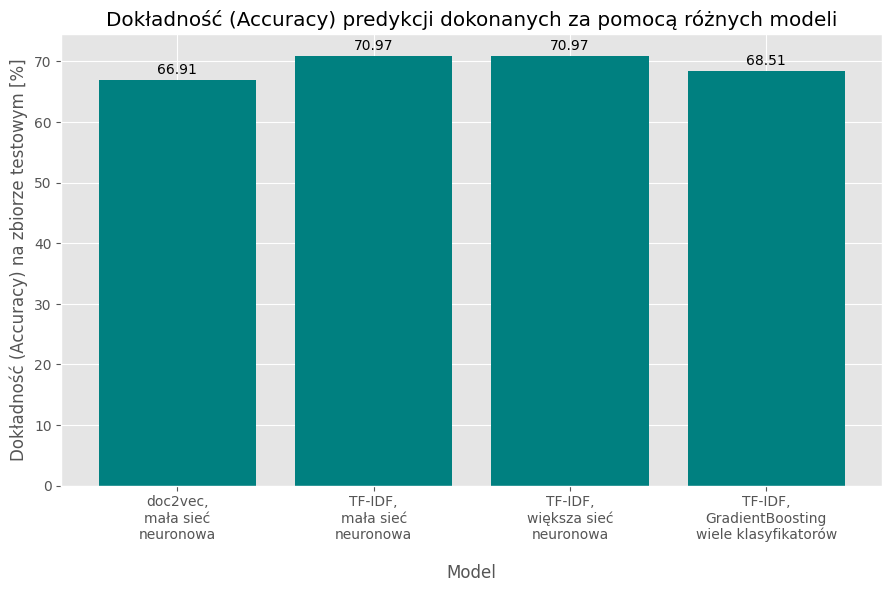

In [90]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

keys = ['doc2vec,\nmała sieć\nneuronowa', 'TF-IDF,\nmała sieć\nneuronowa', 'TF-IDF,\nwiększa sieć\nneuronowa', 'TF-IDF,\nGradientBoosting\nwiele klasyfikatorów\n']
values = [val*100 for val in list(tested_options_acc.values())]


plt.figure(figsize=(9, 6))
bars = plt.bar(keys, values, color='teal')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Dokładność (Accuracy) na zbiorze testowym [%]')
plt.title('Dokładność (Accuracy) predykcji dokonanych za pomocą różnych modeli')

plt.tight_layout(pad=1)
plt.savefig('ml_classifier_accuracy.png')
plt.show()

In [73]:
tested_options_recall = {
    'doc2vec_simple_nn_recall': doc2vec_simple_nn_recall,
    'tfidf_simple_nn_recall': tfidf_simple_nn_recall,
    'tfidf_bigger_nn_recall': tfidf_bigger_nn_recall,
    'tfidf_gb_recall': tfidf_gb_recall,
}

tested_options_recall

{'doc2vec_simple_nn_recall': 0.7346125849668288,
 'tfidf_simple_nn_recall': 0.7766475638498401,
 'tfidf_bigger_nn_recall': 0.7787785121376258,
 'tfidf_gb_recall': 0.7372439629118616}

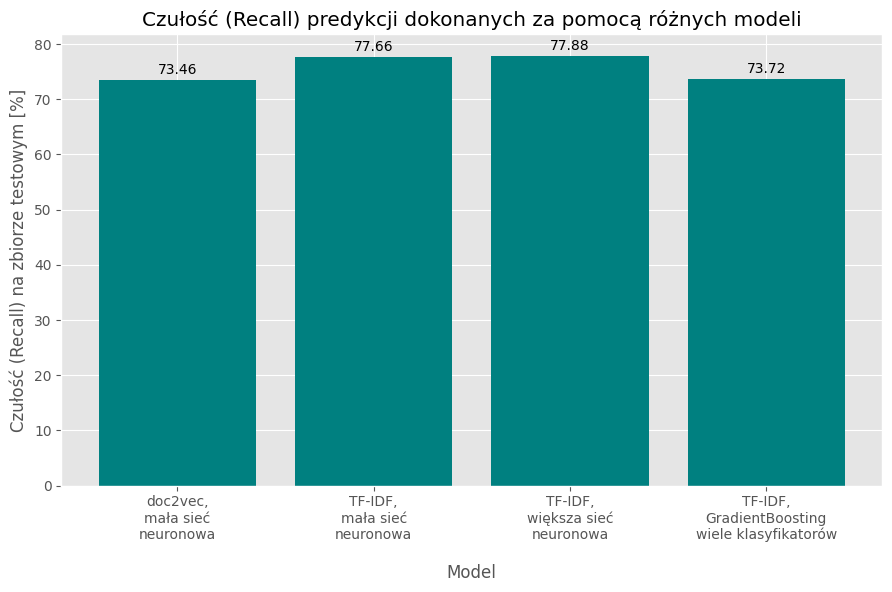

In [89]:
values = [val*100 for val in list(tested_options_recall.values())]


plt.figure(figsize=(9, 6))
bars = plt.bar(keys, values, color='teal')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Czułość (Recall) na zbiorze testowym [%]')
plt.title('Czułość (Recall) predykcji dokonanych za pomocą różnych modeli')

plt.tight_layout(pad=1)
plt.savefig('ml_classifier_recall.png')
plt.show()

In [75]:
tested_options_precision = {
    'doc2vec_simple_nn_precision': doc2vec_simple_nn_precision,
    'tfidf_simple_nn_precision': tfidf_simple_nn_precision,
    'tfidf_bigger_nn_precision': tfidf_bigger_nn_precision,
    'tfidf_gb_precision': tfidf_gb_precision,
}

tested_options_precision

{'doc2vec_simple_nn_precision': 0.5523979500769713,
 'tfidf_simple_nn_precision': 0.6287660676456441,
 'tfidf_bigger_nn_precision': 0.6074554151256809,
 'tfidf_gb_precision': 0.5966024220044214}

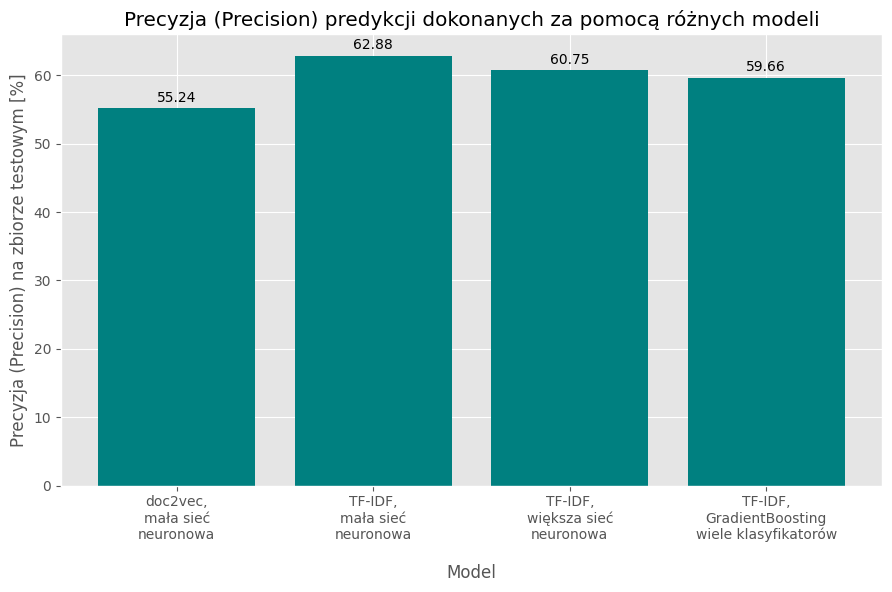

In [88]:
values = [val*100 for val in list(tested_options_precision.values())]


plt.figure(figsize=(9, 6))
bars = plt.bar(keys, values, color='teal')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Precyzja (Precision) na zbiorze testowym [%]')
plt.title('Precyzja (Precision) predykcji dokonanych za pomocą różnych modeli')

plt.tight_layout(pad=1)
plt.savefig('ml_classifier_precision.png')
plt.show()